In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# 필요한 데이터 로드
bad_users_03 = pd.read_csv("/opt/ml/input/workspace/TestRecall/bad_user_id03.csv", header=None).to_numpy().reshape(-1)
bad_users_02 = pd.read_csv("/opt/ml/input/workspace/TestRecall/bad_user_id_02.csv", header=None).to_numpy().reshape(-1)
good_users_05 = pd.read_csv("/opt/ml/input/workspace/TestRecall/good_user_id05.csv", header=None).to_numpy().reshape(-1)
raw_data_og = pd.read_csv("/opt/ml/input/data/train/train_ratings.csv")
raw_data = raw_data_og.groupby("user")["item"].apply(list) # 유저 별로 시청한 데이터를 리스트로 정리
years = pd.read_csv("/opt/ml/input/data/train/years.tsv", delimiter = "\t")
titles = pd.read_csv("/opt/ml/input/data/train/titles.tsv", delimiter="\t")
genre_og = pd.read_csv("/opt/ml/input/data/train/genres.tsv", delimiter="\t")
genre = genre_og.groupby("item")["genre"].apply(list) # 각 영화별 장르를 리스트로 정리
views = pd.read_csv("views.csv")

In [6]:
all_users = raw_data_og["user"].unique()
rest_users = np.setdiff1d(all_users, bad_users_03)

In [4]:
views["views"][0]

18168

In [3]:
years_dict = dict()
for i in range(len(years)) :
    it = years.loc[i]["item"]
    yr = years.loc[i]["year"]
    years_dict[it] = yr

titles_dict = dict()
for i in range(len(titles)) :
    id = titles.loc[i]["item"]
    ti = titles.loc[i]["title"]
    titles_dict[id] = ti

genres_dict = dict()
for key in genre.keys() :
    gr = genre.loc[key]
    genres_dict[key] = gr

cnt = 0
views_dict = dict()
for item in views["item"] :
    views_dict[item] = views["views"][cnt]
    cnt += 1

In [7]:
item_years = list()
item_titles = list()
item_genres = list()
for user in all_users :
    items = raw_data[user]
    year_list = list()
    titles_list = list()
    genres_list = np.array([])
    for item in items :
        
        if item in years_dict.keys() :
            year_list.append(years_dict[item])
        if item in titles_dict.keys() :
            titles_list.append(titles_dict[item])
        if item in genres_dict.keys() :
            #genres_list.append(genres_list[item])
            genres_list = np.concatenate((genres_list, genres_dict[item]))

    item_years.append(year_list)
    item_titles.append(titles_list)
    item_genres.append(genres_list)


In [45]:
le = list()
for user in bad_users_02 :
    items = raw_data[user]
    for item in items:
        le.append(len(genres_dict[item]))
np.array(le).mean()

2.7575148778256553

In [8]:
median_var_g = list()
medians_g = list()
vars_g = list()
for i in item_genres :
    genre_dist = np.unique(i, return_counts=True)[1]
    var = np.array(genre_dist).var()/np.array(genre_dist).mean()
    median = np.median(np.array(genre_dist))
    median_var_g.append((var, median))
    medians_g.append(median)
    vars_g.append(var)

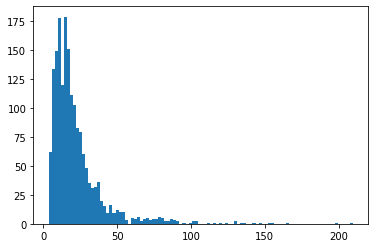

In [21]:
plt.hist(vars_g, bins=100)
plt.show()

In [22]:
np.array(vars_g).mean()

21.931793517968664

In [14]:
badcnt = 0
for var in vars_g :
    if var > 50 :
        badcnt += 1
badcnt / len(vars_g)

0.07802933673469388

In [30]:
median_var = list()
medians = list()
vars = list()
for i in item_years :
    var = np.array(i).var()/len(i)
    median = np.median(np.array(i))
    median_var.append((var, median))
    medians.append(median)
    vars.append(var)

In [39]:
sum(medians_g)/len(medians_g)

19.62324141812043

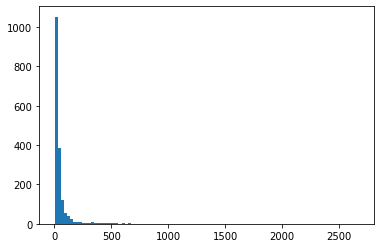

In [34]:
plt.hist(vars_g, bins=100)
plt.show()

In [65]:
genre_list = sorted(genre_og["genre"].unique())
genre_counts_by_user = list()

In [135]:
for i in range(len(item_genres)):
    uniq = np.unique(item_genres[i], return_counts=True)
    counts = list()
    for genre in genre_list :
        if genre in uniq[0] :
            index = np.where(uniq[0]==genre)
            counts.append(int(uniq[1][index]))
        else :
            counts.append(0)
    genre_counts_by_user.append(counts)



In [114]:
genre_count_good_df = pd.DataFrame(data=genre_counts_by_user, columns=genre_list)
genre_count_bad_df = pd.DataFrame(data=genre_counts_by_user, columns=genre_list)

In [136]:
genre_count_df = pd.DataFrame(data=genre_counts_by_user, columns=genre_list)

In [138]:
genre_count_df.corr().to_csv("./genre_corr/genre_corr_all_user.csv")

In [ ]:
sns.set(rc={'figure.figsize':(14,12)})
plot = sns.heatmap(genre_count_df.corr(), 
        xticklabels=genre_list,
        yticklabels=genre_list,
        cmap="YlGnBu",
        annot=True)
fig = plot.get_figure()
fig.savefig("./genre_corr/genre_corr_all_users.jpeg")

In [125]:
# 나쁜 유저와 좋은 유저의 장르 상관관계 차이 TODO : 따로 저장하는 코드를 추가해야 한다
bad_corr = genre_count_bad_df.corr()
good_corr = genre_count_good_df.corr()
loss = 0
for genre in genre_list :
    bad = bad_corr[genre]
    good = good_corr[genre]
    for i in range(18) :
        loss += abs(bad[i]-good[i])

In [127]:
bad_user_item_count = list()
good_user_item_count = list()
for bad_user in bad_users_02 :
    item_length = len(raw_data[bad_user])
    bad_user_item_count.append(item_length)
for good_user in good_users_05 :
    item_len = len(raw_data[good_user])
    good_user_item_count.append(item_len)

In [133]:
print(max(bad_user_item_count))
print(max(good_user_item_count))

print(min(bad_user_item_count))
print(min(good_user_item_count))

print(np.mean(bad_user_item_count))
print(np.mean(good_user_item_count))

print(np.var(bad_user_item_count)/len(bad_user_item_count))
print(np.var(good_user_item_count)/len(good_user_item_count))


1117
1760
37
41
107.76972652847935
168.92290377039956
1.1439040906046698
11.10286108713463


In [66]:
genre_count_dict = dict()
for genre in genre_list :
    genre_count_dict[genre] = 0

In [160]:
for i in item_genres :
    for item in i :
        genre_count_dict[item] += 1

In [161]:
sorted(genre_count_dict, key=lambda x : genre_count_dict[x], reverse=True)

['Drama',
 'Comedy',
 'Action',
 'Thriller',
 'Adventure',
 'Crime',
 'Sci-Fi',
 'Romance',
 'Fantasy',
 'Mystery',
 'Children',
 'Animation',
 'Horror',
 'War',
 'Musical',
 'Western',
 'Documentary',
 'Film-Noir']

In [35]:
item_views = list() 

for user in bad_users_02 :
    items = raw_data[user]
    vl = list()
    for item in items :
        vl.append(views_dict[item])
    item_views.append(vl)

In [36]:
view_mean = list()
view_var = list()
for i in item_views :
    if len(i)==0 :
        view_mean.append(0)
        continue
    view_mean.append(np.mean(i))
    view_var.append(np.sqrt(np.var(i)))

In [37]:
print(np.mean(view_mean))
print(np.mean(view_var))


5385.714775965616
4630.422725681959


In [54]:
popularity_count = 0
total_count = 0
for i in item_views :
    for item in i :
        if 60 <= item <150:
            popularity_count +=1
        total_count += 1

In [55]:
popularity_count/total_count

0.03169518317262157

In [62]:
item_years = list()
item_titles = list()
item_genres = list()
for user in bad_users_02 :
    items = raw_data[user]
    year_list = list()
    titles_list = list()
    genres_list = np.array([])
    for item in items :
        
        #if item in years_dict.keys() :
        #    year_list.append(years_dict[item])
        #if item in titles_dict.keys() :
        #    titles_list.append(titles_dict[item])
        if item in genres_dict.keys() and item in years_dict.keys():
            if years_dict[item] >= 1980 :
                #genres_list.append(genres_list[item])
                genres_list = np.concatenate((genres_list, genres_dict[item]))

    item_years.append(year_list)
    item_titles.append(titles_list)
    item_genres.append(genres_list)


In [63]:
item_genres

[array(['Action', 'Drama', 'Thriller', 'Comedy', 'Drama', 'Romance',
        'Comedy', 'Drama', 'Romance', 'Comedy', 'Drama', 'Romance',
        'Drama', 'Drama', 'Mystery', 'Comedy', 'Drama', 'Fantasy',
        'Romance', 'Sci-Fi', 'Drama', 'Horror', 'Thriller', 'Drama',
        'Comedy', 'Drama', 'Drama', 'Action', 'Crime', 'Thriller', 'Drama',
        'Adventure', 'Comedy', 'Drama', 'Drama', 'Fantasy', 'Romance',
        'Drama', 'Fantasy', 'Thriller', 'Comedy', 'Crime', 'Drama',
        'Thriller', 'Action', 'Crime', 'Drama', 'Thriller', 'Mystery',
        'Thriller', 'Drama', 'Fantasy', 'Romance', 'Comedy', 'Drama',
        'Drama', 'Romance', 'Drama', 'Romance', 'Sci-Fi', 'Drama', 'Crime',
        'Drama', 'Thriller', 'Drama', 'Romance', 'Drama', 'Fantasy',
        'Romance', 'Drama', 'Mystery', 'Romance', 'War', 'Action', 'Crime',
        'Drama', 'Thriller', 'War', 'Drama', 'Action', 'Drama', 'Romance',
        'Adventure', 'Comedy', 'Fantasy', 'Comedy', 'Romance', 'Adventure',

In [67]:
for i in range(len(item_genres)):
    uniq = np.unique(item_genres[i], return_counts=True)
    counts = list()
    for genre in genre_list :
        if genre in uniq[0] :
            index = np.where(uniq[0]==genre)
            counts.append(int(uniq[1][index]))
        else :
            counts.append(0)
    genre_counts_by_user.append(counts)



In [69]:
median_var_g = list()
medians_g = list()
vars_g = list()
for i in item_genres :
    genre_dist = np.unique(i, return_counts=True)[1]
    var = np.array(genre_dist).var()/len(genre_dist)
    median = np.median(np.array(genre_dist))
    median_var_g.append((var, median))
    medians_g.append(median)
    vars_g.append(var)

In [71]:
sum(vars_g)/len(vars_g)

17.8843755183281

In [77]:
total_count = np.array(genre_counts_by_user).sum(axis=0)

In [79]:
ll = list()
for i in range(18) :
    ll.append((genre_list[i],total_count[i]))

In [82]:
ll.sort(key = lambda x:x[1], reverse=True)

[('Drama', 256729),
 ('Comedy', 178981),
 ('Action', 166885),
 ('Thriller', 155373),
 ('Adventure', 129394),
 ('Crime', 109647),
 ('Romance', 94059),
 ('Sci-Fi', 93729),
 ('Fantasy', 67626),
 ('Mystery', 51525),
 ('Children', 41544),
 ('Animation', 41305),
 ('Horror', 31051),
 ('War', 29405),
 ('Musical', 14143),
 ('Documentary', 8633),
 ('Western', 6500),
 ('Film-Noir', 4763)]

In [122]:
user_timestamp = raw_data_og.groupby("user")["time"].apply(list)
bad_user_timestamp = user_timestamp[bad_users_02]
good_user_timestamp = user_timestamp[good_users_05]

In [125]:
timestamp = good_user_timestamp

In [126]:
for i in range(len(timestamp)) :
    for j in range(len(timestamp.iloc[i])) :
        timestamp.iloc[i][j] = dt.datetime.fromtimestamp(timestamp.iloc[i][j]).year

In [127]:
for i in range(len(timestamp)) :
    print(timestamp.iloc[i])

[2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006]
[2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 20

In [128]:
timestamp_data = list()
ma_list = list()
mi_list = list()
term_list=list()
for i in range(len(timestamp)) :
    ma = max(timestamp.iloc[i])
    mi = min(timestamp.iloc[i])
    timestamp_data.append((ma, mi, ma-mi))
    ma_list.append(ma)
    mi_list.append(mi)
    term_list.append(ma-mi)

In [130]:
cnt = 0
for i in timestamp_data :
    if i[2] < 1:
        cnt +=1

cnt

923

In [131]:
mama = 0
for i in timestamp_data :
    if i[2] > mama :
        mama = i[2]
mama

10

In [133]:
print(np.mean(np.array(ma_list)))
print(np.mean(np.array(mi_list)))
print(np.mean(np.array(term_list)))

2009.292628024761
2007.4389420371413
1.8536859876195835


In [118]:
min(mi_list)

2005

In [137]:
timestamp
for i in range(len(raw_data_og)) :
    user = raw_data_og[i]["user"]
    if user in bad_users_02 :


user            11
item          4643
time    1230782529
Name: 0, dtype: int64